# Music Machine Learning - Gaussian Mixture Models

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. Unsupervised learning and [clustering](#clustering).
2. Motivating the need for [latent variable](#latent) models.
2. Approaching the problem naïvely with the [k-Means](#kmeans) algorithm.

We begin with the standard imports

In [215]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from helper_plot import hdr_plot_style

hdr_plot_style()

## Defining mixture models

We have seen previously how to fit a Gaussian, so we could apply the same reasoning and try to fit a single multivariate Gaussian to our dataset
$$
\begin{align}
p(\mathbf{x} \vert \theta) &= \mathcal{N}\left(\mathbf{x}\vert \mu, \Sigma\right) \\
\theta &= \{\mu, \Sigma\}
\end{align}
$$
However, we can quickly see that our data contains several groups, and the single Gaussian seems largely not adapted.

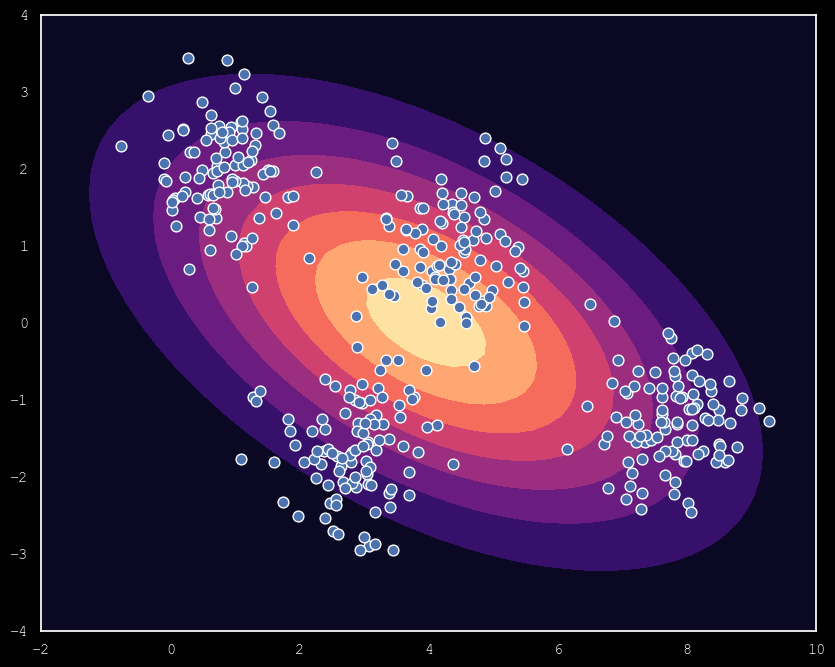

In [216]:
from helper_plot import fit_multivariate_gaussian
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1]
labels = fit_multivariate_gaussian(X)

Instead of using a single Gaussian, we could use several Gaussians, for instance, if we use three Gaussians, we have the following model
$$
\begin{align}
p(\mathbf{x} \vert \theta) &= \pi_{1} \mathcal{N}\left(\mathbf{x}\vert \mu_{1}, \Sigma_{1}\right) \\
&+ \pi_{2} \mathcal{N}\left(\mathbf{x}\vert \mu_{2}, \Sigma_{2}\right)\\
&+ \pi_{3} \mathcal{N}\left(\mathbf{x}\vert \mu_{3}, \Sigma_{3}\right)\\
&+ \pi_{4} \mathcal{N}\left(\mathbf{x}\vert \mu_{4}, \Sigma_{4}\right)\\
\end{align}
$$
So now the parameters are both the parameters of each Gaussian, along with the probabilities of belonging to each Gaussian
$$
\theta = \{\pi_{1}, \pi_{2}, \pi_{3}, \pi_{4}, \mu_{1}, \mu_{2}, \mu_{3}, \mu_{4}, \Sigma_{1}, \Sigma_{2}, \Sigma_{3}, \Sigma_{4}\}
$$
Note that if we solve this model, called a _Gaussian Mixture Model_ (GMM), we can find the probabilities of each point belonging to one of the corresponding cluster

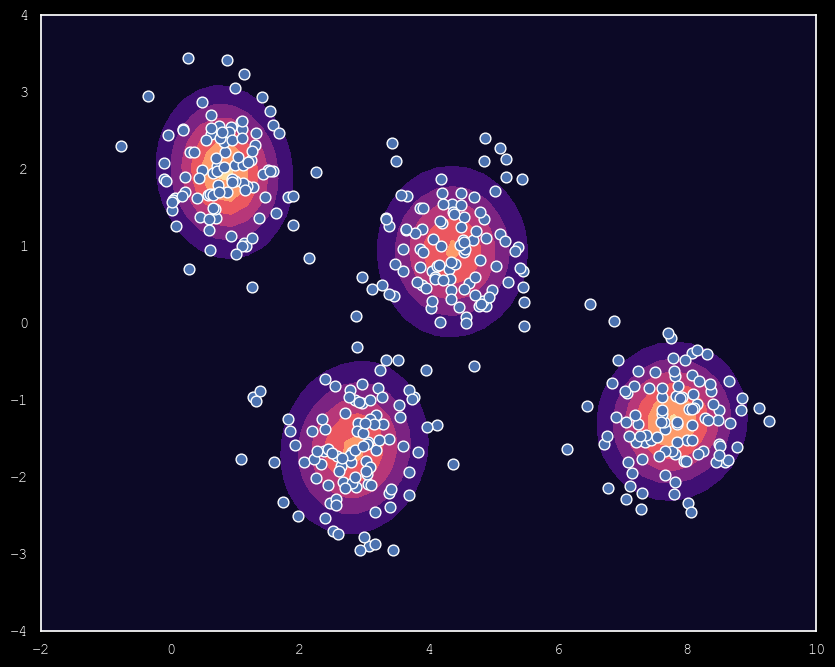

In [217]:
from helper_plot import fit_gaussian_mixture
labels = fit_gaussian_mixture(X)

Compared to a single Gaussian, a GMM has obviously a higher flexibility, but also a larger number of parameters (which makes it harder to optimize). Generally speaking, the full distribution of a GMM is defined as follows
$$
p(\mathbf{x} \vert \theta) = \sum_{c} \pi_{c} \mathcal{N}\left(\mathbf{x}\vert \mu_{c}, \Sigma_{c}\right)
$$

We can see that any *mixture model*, is defined through two main components.

**Base distribution**: $p(\mathbf{x}\vert z=c, \theta) = \mathcal{N}\left(\mathbf{x}\vert \mu_{c}, \Sigma_{c}\right)$

**Mixing probabilities** $p(z=c \vert \theta) = \pi_{c}$

### Optimizing this model

If we want to optimize our probabilistic model, we have to solve a typical *maximum likelihood* problem (considering that points $x_{i}$ are independent)
$$
\underset{\theta}{\text{max. }} p(x \vert \theta) = \prod_{i=1}^{N} p(x_{i} \vert \theta)
$$
In the case of a GMM, we could try to replace our full model inside this problem, which leads to a rather complicated formulation.
$$
\underset{\theta}{\text{max. }} \prod_{i=1}^{N} \sum_{c} \pi_{c} \mathcal{N}\left(x_{i}\vert \mu_{c}, \Sigma_{c}\right)
$$

Furthermore, we have to include the following constraints
$$
\sum_{c} \pi_{c} = 1; \pi_{c} \geq 0, \forall c \\
\Sigma_{c} \succcurlyeq 0
$$

Although, we could rely on optimization, we need to incorporate hard to follow constraints, which leads to slow and unstable training. Here, the reasoning is way easier if we introduce a latent variable

### Introducing a latent variable

We introduce the latent variable $z$, which _explains_ a given datapoint. In our case, this variable tells us _from which group_ the point was generated.

In our case, we can simply say that our latent variable corresponds to the mixing probabilities
$$
\begin{align}
p(z=c\vert\theta) &= \pi_{c} \\
p(\mathbf{x}\vert z=c,\theta) &= \mathcal{N}\left(\mathbf{x}\vert \mu_{c}, \Sigma_{c}\right)
\end{align}
$$

Therefore, our original model can be retrieved as a marginalization of the latent variable, as
$$
p(\mathbf{x} \vert \theta) = \sum_{c} p(\mathbf{x} \vert z=c,\theta) p(z=c\vert\theta)
$$

#### Estimating parameters

Now in order to optimize the parameters, we should need to optimize both the $\theta$ and $z$ variables. If we knew the cluster belonging (latent) variable $z$, then the optimization would be easy, since we know that
$$
p(\mathbf{x}\vert z=c, \theta) = \mathcal{N}\left(\mathbf{x}\vert \mu_{c}, \Sigma_{c}\right)
$$
And computing the parameters of this Gaussian is pretty easy, as we simply need to update the values depending on the corresponding points (weighted mean)
$$
\mu_{c} = \frac{\sum_{i} p(z=i\vert \mathbf{x}_{i}, \theta) x_{i}}{\sum_{i} p(z=i\vert \mathbf{x}_{i}, \theta)}
$$

Now in order to optimize the source variable $z$, the optimization would be easy if we knew the parameters as we have
$$
p(z = c \vert \mathbf{x}, \theta) = \frac{p(\mathbf{x} \vert z = c, \theta) p(z = c \vert \theta)}{Z}
$$

## Expectation-Maximization

As we have seen in the slides, a natural alternating solution emerges in the form of the **Expectation-Maximization** algorithm
1. Start with a random set of Gaussians parameters $\theta^{(0)}$
2. Repeat until convergence
    1. *E-step*: for each point, find weights encoding the probability of membership in each cluster by computing $p(z=c \vert \mathbf{x}_{i}, \theta^{(t)})$
    2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights, hence updating Gaussian parameters $\theta^{(t+1)}$

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.

### Deriving the E-Step
As discussed in the slides, we want to minimize the gap between our lower bound and the true distribution, which can be written as
$$
\mathcal{D} = \log p(\mathbf{x} \vert \theta) - \mathcal{L}(\theta\vert q)
$$
Developing this expression, we find out that
$$
\mathcal{D} = \sum_{i=1}^{N} \mathcal{D}_{KL} \left[ q(z_{i}) \Vert p(z_{i} \vert \mathbf{x}_{i}, \theta) \right]
$$
Hence, we need to minimize the KL divergence, which amounts to setting the approximate function as the posterior distribution
$$
q(z_{i}) = p(z_{i} \vert \mathbf{x}_{i}, \theta)
$$

### Deriving the M-step

Based on the approximation that we want to maximize
$$
\mathcal{L}(\theta, q) = \sum_{i=1}^{N} \sum_{c} q(t_{i}=c) \log\frac{p(x_{i}, t_{i}=c \vert \theta)}{q(t_{i}=c)}
$$
We have seen that expending this maximization led to
$$
\mathcal{L}(\theta, q) = \mathbb{E}_{q} \log p(x,t\vert \theta) + const
$$
Note that the fonction is usually concave, which makes it easy to optimize

## Using GMM with `scikit-learn`

By using the EM algorithm, a GMM will find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset, which can elegantly solve our clustering problem.

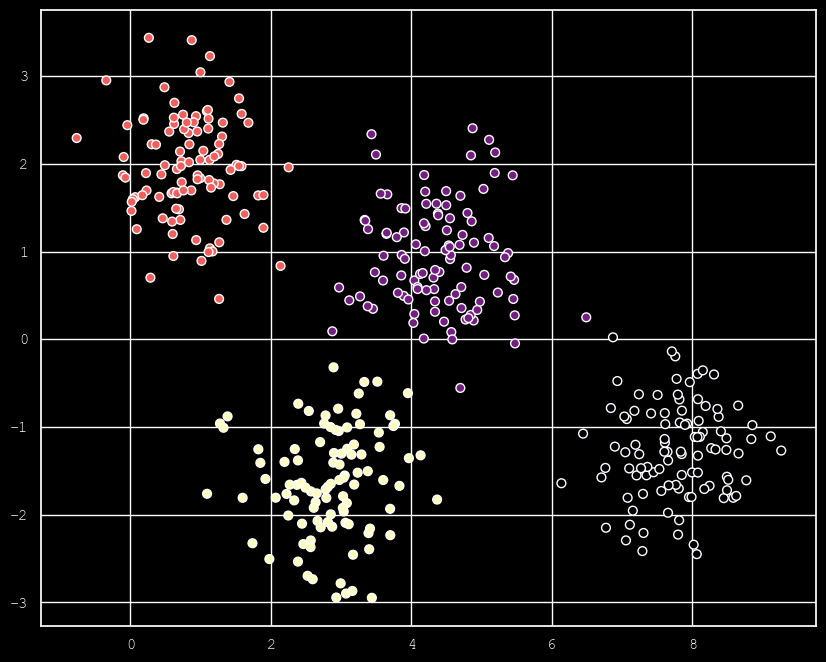

In [218]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='magma', edgecolor='w')

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [219]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.463 0.537 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

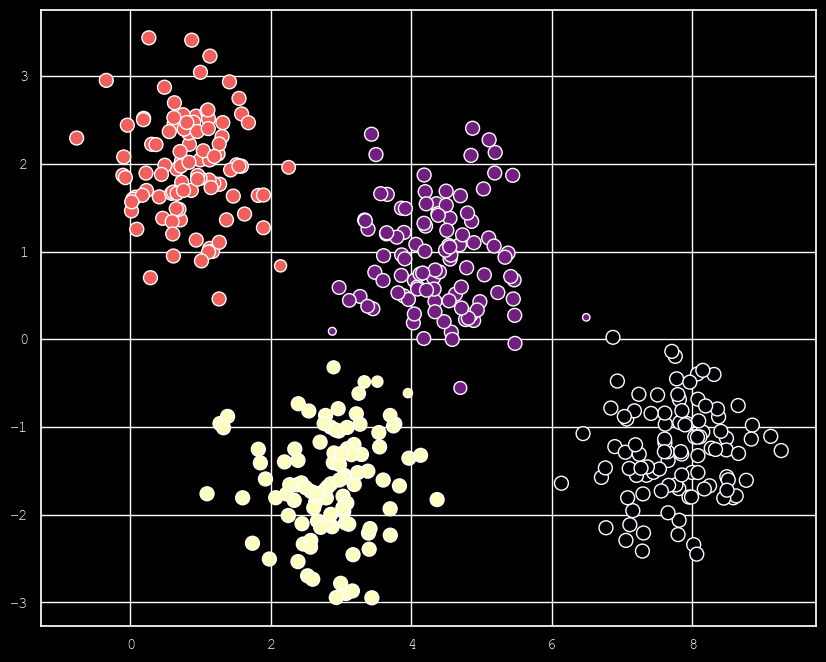

In [220]:
size = 100 * (probs.max(1) ** 2)  # square emphasizes differences
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='magma', s=size, edgecolor='w')

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

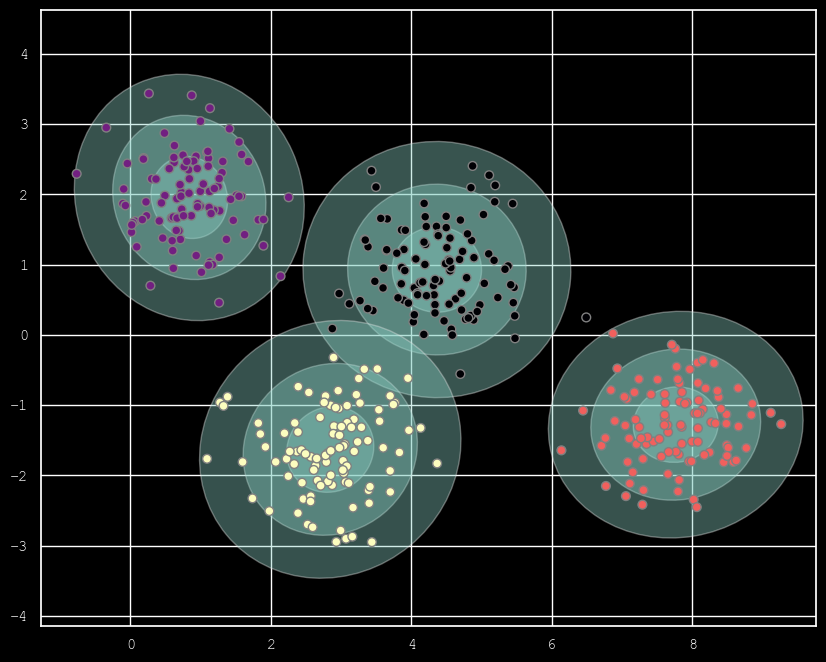

In [221]:
from helper_plot import plot_gmm

gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset. Here, we already see that allowing for a full covariance the model will fit even very oblong, stretched-out clusters (as opposed to the *hard* version of kMeans)

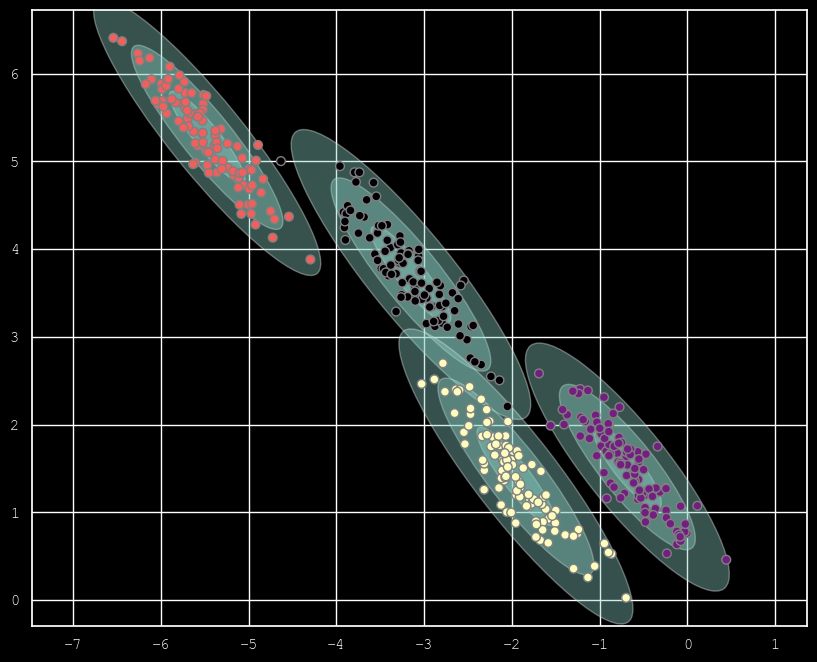

In [222]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

## Implementing EM for GMM

Now, we will derive and implement formulas for the GMM ourselves. To do so, we will use samples from a Gaussian mixture model with unknown mean, variance, and priors. We will also have to derive both the E-step and M-step for our selected model.

### Reminder

We recall that the EM algorithm is a coordinate descent optimization of a lower bound 
$$
\underset{\theta}{\text{argmax }} \mathcal{L}(\theta, q) = \underset{\theta}{\text{argmax }} \int q(\mathbf{z}) \log\frac{p(\mathbf{x}, \mathbf{z} \vert \theta)}{q(\mathbf{z})}d\mathbf{z}
$$

**E-step**: In the E-step, we use a lower-bounding approximation to find the latent variables $\mathbf{z}$, while using the current parameters estimate $\theta^{(t)}$
$$
\underset{q}{\text{argmax }} \mathcal{L}(\theta, q) \Leftrightarrow \underset{q}{\text{argmin }} \mathcal{D}_{KL} \left[q(\mathbf{z}) \Vert p(\mathbf{z}\vert\mathbf{x}, \theta) \right]
$$

We have seen that the optimal solution is $q(\mathbf{z}) = p(\mathbf{z}\vert\mathbf{x}, \theta)$, which means that we can safely use the conditional probability for this step. 

**M-step**: In the M-step, we use our updated knowledge on the latent variable to update the parameters. Hence, we have to optimize
$$
\underset{\theta}{\text{argmax }} \mathcal{L}(\theta, q) \Leftrightarrow \underset{\theta}{\text{argmax }} \mathbb{E}_{q(\mathbf{z})}\log p(\mathbf{x},\mathbf{z} | \theta)
$$

For our GMM model, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component. The *latent variable* $z$ are indices of components to which each data point is assigned, i.e. $z_i$  is the cluster index for object $\mathbf{x}_i$. Therefore, the joint distribution of our GMM can be written as follows

$$\log p(\mathbf{z}, X \mid \theta) =  \sum\limits_{i=1}^N \log p(z_i, x_i \mid \theta) = \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(z_i = c) \log \left (\pi_c \, \mathcal{N}(x_i \mid \mu_c, \Sigma_c)\right)
$$
where $\mathcal{N}(x_i \mid \mu_c, \Sigma_c) = \frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})
\right)$ is the probability density function (pdf) of the normal distribution.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q_i(z_i) = p(z_i \mid \mathbf{x}_i, \theta)$. We assume that $z_i$ equals to the cluster index of the true component of the $\mathbf{x}_i$ object. To do so we need to compute $\pi_{ic} = p(z_i = c \mid \mathbf{x}_i, \theta)$. Note that $\sum\limits_{c=1}^C\pi_{ic}=1$.


***
**Exercise**

1. Implement E-step for GMM using template below.

***

In [223]:
from scipy.stats import multivariate_normal

def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    pi_update: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    pi_update = np.zeros((N, C)) # distribution q(T)
    
    for i in range(N):
        for c in range(C):  
            pi_update[i,c] = multivariate_normal.pdf(X[i], mu[c], sigma[c])
            
        pi_update[i] /= np.sum(pi_update[i])
        
    return pi_update

In [224]:
pi0 = np.random.randn(4, X.shape[0])
mu0 = np.random.randn(4, 2)
sigma0 = np.zeros((4, 2, 2))
for i in range(4):
    sigma0[i] = np.eye(2, 2)
pi = E_step(X, pi0, mu0, sigma0)

In [225]:
pi[0:10]

array([[3.66780745e-03, 7.02046383e-04, 9.95204461e-01, 4.25685410e-04],
       [3.29418722e-01, 6.16870557e-01, 2.54635976e-02, 2.82471238e-02],
       [3.39979462e-01, 5.98302378e-01, 3.79408944e-02, 2.37772658e-02],
       [2.36827002e-02, 6.71071523e-03, 9.64241286e-01, 5.36529889e-03],
       [3.34280227e-01, 6.07085283e-01, 2.70746309e-02, 3.15598584e-02],
       [9.33964756e-03, 2.82708909e-03, 9.87466108e-01, 3.67154857e-04],
       [1.31841734e-01, 5.02791402e-02, 6.97891480e-01, 1.19987645e-01],
       [6.16700652e-02, 2.41864074e-02, 9.03257885e-01, 1.08856424e-02],
       [3.76231342e-01, 4.22652996e-01, 1.59552297e-01, 4.15633645e-02],
       [1.43154894e-01, 5.87827434e-02, 6.99625250e-01, 9.84371125e-02]])

In [226]:
np.sum(pi[0:10], axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, you need to compute the derivatives and 
set them to zero. You should start by deriving formulas for $\mu$ as it is the easiest part. Then move on to $\Sigma$. Here it is crucial to optimize function w.r.t. to $\Lambda = \Sigma^{-1}$ and then inverse obtained result. Finaly, to compute $\pi$, you will need <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">Lagrange Multipliers technique</a> to satisfy constraint $\sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Important note:</b> You will need to compute derivatives of scalars with respect to matrices. To refresh this technique from previous courses, see <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> wiki article</a> about it . Main formulas of matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>. For example, there you may find that 
$\frac{\partial}{\partial A}\log |A| = A^{-T}$.


<b>Task 2:</b> Implement M-step for GMM using template below.

In [227]:
def M_step(X, pi_update):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi_update: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = pi_update.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    
    mu = np.zeros((C,d))
    pi = np.zeros(C)
    sigma = np.zeros((C,d,d))
    for c in range(C):
        for i in range(N):
            mu[c] += pi_update[i,c] * X[i]
        mu[c] /= np.sum(pi_update[:,c])
        
        sigma_c = 0
        for i in range(N):
            sigma_c += pi_update[i, c] * ((X[i]-mu[c]).T * (X[i]-mu[c]))
        sigma[c] = (sigma_c / np.sum(pi_update[:,c])) * np.eye(d)
        
        pi[c] = (1/N) * np.sum(pi_update[:,c])
        
    return pi, mu, sigma

In [228]:
pi_update = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, pi_update)

### Loss function

Finally, we need some function to track convergence. We will use variational lower bound $\mathcal{L}$ for this purpose. We will stop our EM iterations when $\mathcal{L}$ will saturate. Usually, you will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, you have a bug in your code.

<b>Task 3:</b> Implement a function that will compute $\mathcal{L}$ using template below.

$$\mathcal{L} = \sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i =c) (\log \pi_c + \log f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)) - \sum_{i=1}^{N} \sum_{c=1}^{K} q(t_i =c) \log q(t_i =c)$$

In [229]:
def compute_vlb(X, pi, mu, sigma, pi_update):
    """
    Each input is numpy array:
    X: (N x d), data points
    pi_update: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = pi_update.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    loss = 0
    for i in range(N):
        for c in range(C):
            f_N = multivariate_normal.pdf(X[i], mu[c], sigma[c])
            loss += pi_update[i,c] * (np.log(pi[c]) + np.log(f_N)) - pi_update[i,c] * np.log(pi_update[i,c])
    
    return loss

In [230]:
pi, mu, sigma = pi0, mu0, sigma0
pi_update = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, pi_update)
loss = compute_vlb(X, pi, mu, sigma, pi_update)

### Bringing it all together

Now that we have E step, M step and VLB, we can implement the training loop. We will initialize values of $\pi$, $\mu$ and $\Sigma$ to some random numbers, train until $\mathcal{L}$ stops changing, and return the resulting points. We also know that the EM algorithm converges to local optima. To find a better local optima, we will restart the algorithm multiple times from different (random) starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Remember, that initial (random) values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to restart the procedure.

<b>Task 4:</b> Implement training procedure

In [231]:
def train_EM(X, C=4, rtol=1e-4, max_iter=20, restarts=5):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    
    for l in range(restarts):
        print(l,'/',restarts-1)
        try:
            pi0 = np.random.randn(C, X.shape[0])
            pi0 /= np.sum(pi0)
            
            mu0 = np.random.randn(C, d)
            sigma0 = np.zeros((C, d, d))
            for i in range(C):
                sigma0[i] = np.eye(d, d)

            pi, mu, sigma = pi0, mu0, sigma0
            
            pi_update = E_step(X, pi, mu, sigma)
            pi, mu, sigma = M_step(X, pi_update)
            loss = compute_vlb(X, pi, mu, sigma, pi_update)
            print(loss)
            
            # Première initialisation de nos "best paramètres"
            best_loss = loss
            best_pi = pi
            best_mu = mu
            best_sigma = sigma
            
            i = 0
            stop_cond = 1
            while (i <= max_iter) and (stop_cond > rtol):
                loss_prev = loss
                pi_update = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, pi_update)
                loss = compute_vlb(X, pi, mu, sigma, pi_update)
                print(loss)
                stop_cond = np.abs((loss - loss_prev) / loss_prev)
                i += 1
              
            # On cherche à maximiser la loss, donc à chaque fois que la loss est supérieur à la précédente, on garde les paramètres pi, sigma et mu
            if loss > best_loss:
                best_loss = loss
                best_pi = pi
                best_mu = mu
                best_sigma = sigma
                
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass
    
    return best_loss, best_pi, best_mu, best_sigma

In [232]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, C=4)

0 / 4
-1679.3542284864377
-1527.8298914774784
-1496.4099092517383
-1457.6951921598616
-1385.2048737405212
-1293.8324470763755
-1268.1168112316147
-1265.6853251058608
-1265.48498683247
-1265.4612749468504
1 / 4
-1653.927754199437
-1555.9076797498658
-1524.661627241144
-1503.5203663051445
-1500.730957652558
-1498.2500788478974
-1494.1223536620346
-1487.8564825721235
-1477.7693812196505
-1459.6165102166517
-1425.3644526031742
-1389.336335247905
-1385.0442664451791
-1384.7014273084587
-1384.6235754905485
2 / 4
-1571.9956797846635
-1528.7784830813691
-1497.0885705409994
-1495.7859247335703
-1494.696379980258
-1492.3411803533415
-1489.5895813585255
-1487.2226012174424
-1485.7011860952425
-1484.9031285021686
-1484.5126756734023
-1484.3216457303317
-1484.2251539051017
3 / 4
-1633.7680960409311
-1504.350124847917
-1452.0098392482432
-1422.419453729852
-1371.068624295282
-1304.6125388909254
-1267.8737998177485
-1265.7192565002788
-1265.5008496120001
-1265.4692381289224
4 / 4
-1663.000238001519
-

If you implemented all the steps correctly, your algorithm should converge in about 20 iterations. Let's plot the clusters to see it. We will assign a cluster label as the most probable cluster index. This can be found using a matrix $\gamma$ computed on last E-step. 

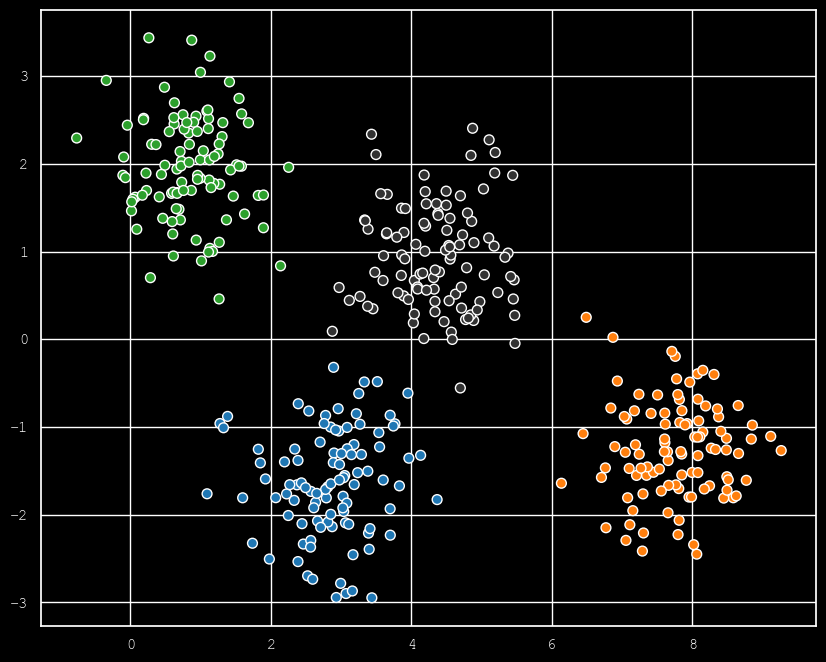

In [214]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(axis=1)
colors = np.array([(31, 119, 180), (255, 127, 14), (44, 160, 44), (50, 50, 50)]) / 255.

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=colors[labels], s=50, edgecolors='w')

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function, which we saw in [In Depth: K-Means Clustering](05.11-K-Means.ipynb):

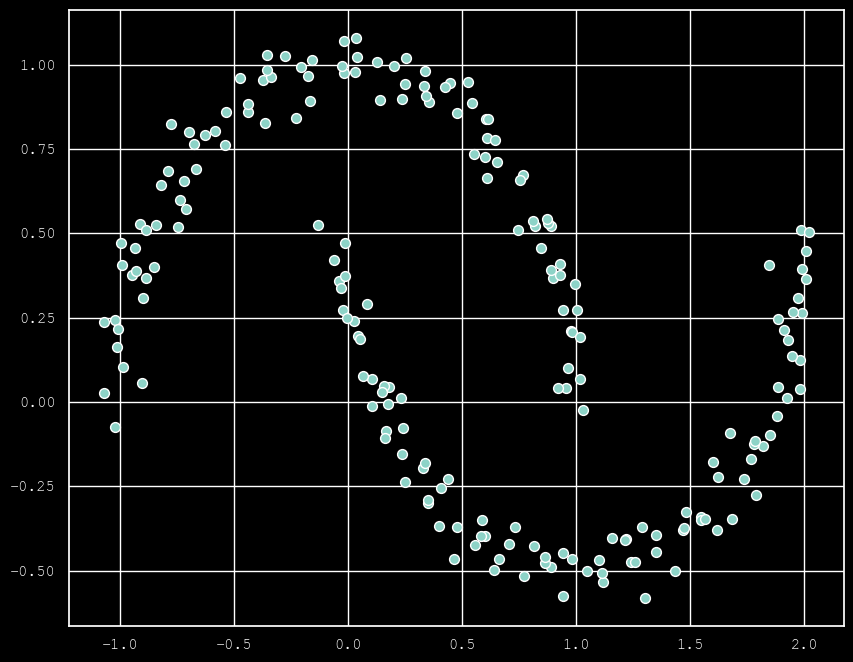

In [200]:
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)

plt.figure(figsize=(10, 8))
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], edgecolor='w', s=50)

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

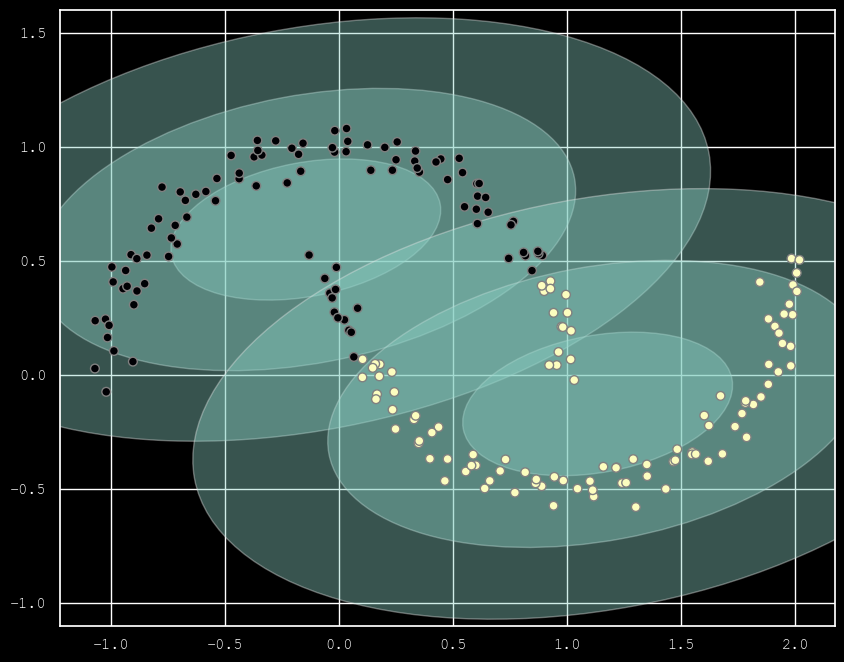

In [179]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

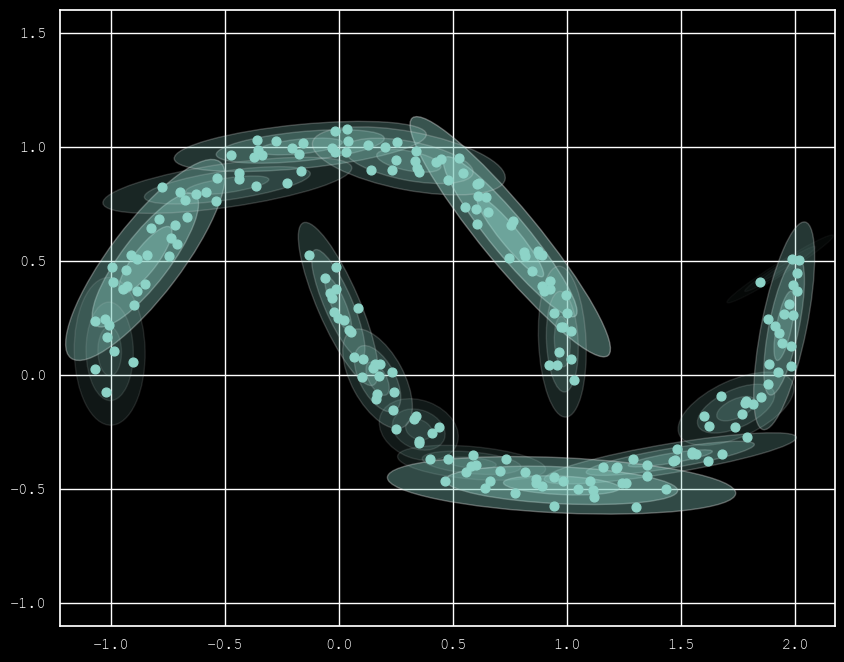

In [180]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

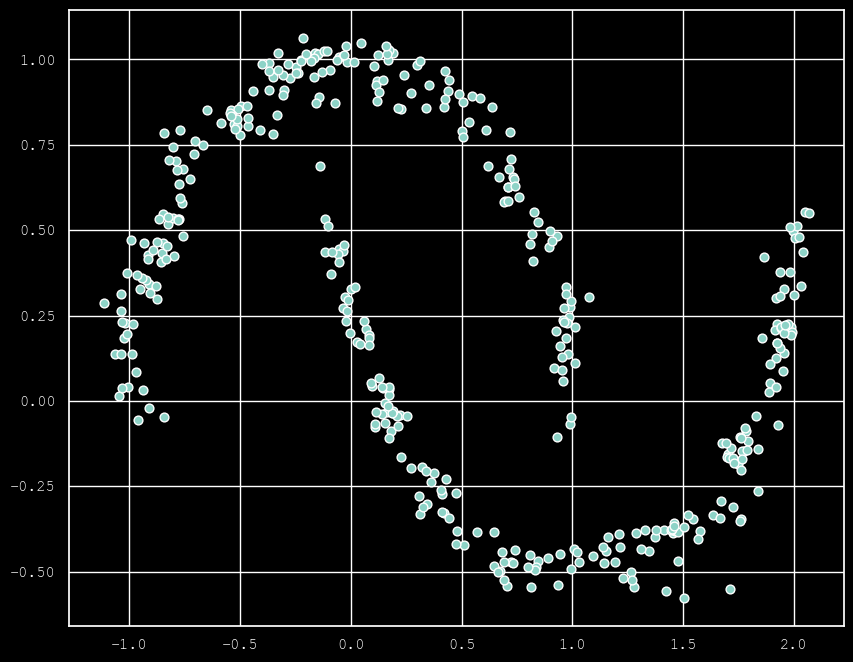

In [181]:
Xnew = gmm16.sample(400)[0]

plt.figure(figsize=(10, 8))
plt.scatter(Xnew[:, 0], Xnew[:, 1], s=40, edgecolor='w')

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

Text(0.5, 0, 'n_components')

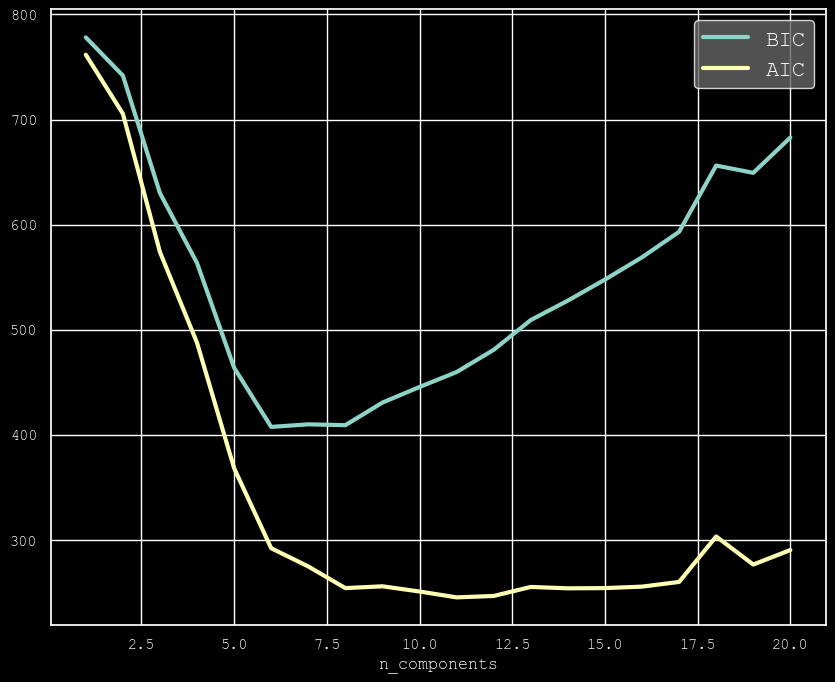

In [182]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.figure(figsize=(10, 8))
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.